In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

### Load Data

In [3]:
if os.path.exists('final_project.db'):
    dill.load_session('final_project.db')

In [4]:
if not os.path.exists('final_project.db'):
    df_2019 = pd.read_csv('../run_ww_2019_w.csv')
    df_2020 = pd.read_csv('../run_ww_2020_w.csv')

In [5]:
# convert 2019 objects to correct types
df_2019['datetime'] = pd.to_datetime(df_2019['datetime'], format='%Y-%m-%d')
df_2019['gender'] = df_2019['gender'].astype('category')
df_2019['age_group'] = df_2019['age_group'].astype('category')
df_2019['country'] = df_2019['country'].astype('category')
df_2019['major'] = df_2019['major'].astype('category')
df_2019.drop(columns=['Unnamed: 0'], inplace=True)

# convert 2020 objects to correct types
df_2020['datetime'] = pd.to_datetime(df_2020['datetime'], format='%Y-%m-%d')
df_2020['gender'] = df_2020['gender'].astype('category')
df_2020['age_group'] = df_2020['age_group'].astype('category')
df_2020['country'] = df_2020['country'].astype('category')
df_2020['major'] = df_2020['major'].astype('category')
df_2020.drop(columns=['Unnamed: 0'], inplace=True)

display(df_2019.head())
display(df_2020.head())

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019
1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016
2,2019-01-01,2,9.30,98.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2019-01-01,3,103.13,453.40,M,18 - 34,United Kingdom,LONDON 2017
4,2019-01-01,4,34.67,185.65,M,35 - 54,United States,BOSTON 2017


,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,70.33,394.200000,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,14.65,79.066667,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,41.41,195.666667,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,41.34,209.100000,M,35 - 54,United States,BOSTON 2017


### Add marathon features

In [6]:
marathon_map = {
    'CHICAGO': '10-12',
    'BERLIN': '09-21',
    'LONDON': '04-27',
    'BOSTON': '04-21',
    'NEW YORK': '11-02'
}
from datetime import timedelta
df_2019['datetime'] = pd.to_datetime(df_2019['datetime'])

df_expanded = df_2019.copy()
df_expanded['major_split'] = df_expanded['major'].str.split(',')
df_expanded = df_expanded.explode('major_split')

df_expanded[['event', 'year']] = df_expanded['major_split'].str.extract(r'(\D+)\s+(\d{4})')
df_expanded['event'] = df_expanded['event'].str.strip()
df_expanded['year'] = df_expanded['year'].astype(int)
df_expanded['major_date'] = pd.to_datetime(
    df_expanded['year'].astype(str) + '-' + df_expanded['event'].map(marathon_map),
    errors='coerce'
)

In [7]:
one_month = pd.Timedelta(days=30)

# Check conditions
df_expanded['within-month-before'] = (
    (df_expanded['datetime'] > df_expanded['major_date'] - one_month) &
    (df_expanded['datetime'] <= df_expanded['major_date'])
)

df_expanded['within-month-after'] = (
    (df_expanded['datetime'] > df_expanded['major_date']) &
    (df_expanded['datetime'] <= df_expanded['major_date'] + one_month)
)

# Group back to original rows and aggregate using any()
df_result = df_expanded.groupby(df_expanded.index)[['within-month-before', 'within-month-after']].any()
df_result

,within-month-before,within-month-after
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1893419,False,False
1893420,False,False
1893421,False,False
1893422,False,False


In [8]:
df_2019 = df_2019.join(df_result)

In [9]:
df_2019_new = df_2019.pivot_table(
    index='athlete',
    columns='datetime',
    values=['distance', 'duration', 'within-month-before', 'within-month-after'],
    aggfunc='sum',
    fill_value=0
)
df_2019_new.columns = [
    f'{val}_week_{date.isocalendar()[1]}' for val, date in df_2019_new.columns
]


df_2019_new = df_2019_new.reset_index()
mask = ~df_2019['athlete'].duplicated()
df_2019_new['age_group'] = df_2019[mask]['age_group']
df_2019_new['country'] = df_2019[mask]['country']
df_2019_new['gender'] = df_2019[mask]['gender']
df_2019_new['major'] = df_2019[mask]['major']
age_map = {}
# compute mean age for each age group to convert to numeric
for age_group in df_2019_new['age_group'].unique():
    ages_split = age_group.split()
    mean_age = 0
    if ages_split[1] == '-':
        mean_age = (int(ages_split[0]) + int(ages_split[2])) / 2
    else:
        mean_age = (55 + 75) / 2
    age_map[age_group] = mean_age
df_2019_new['age_group'] = pd.Series(df_2019_new['age_group'].map(age_map), dtype=float)
df_2019_new = pd.get_dummies(df_2019_new, columns=['country'])
df_2019_new

,athlete,distance_week_1,distance_week_2,distance_week_3,distance_week_4,distance_week_5,distance_week_6,distance_week_7,distance_week_8,distance_week_9,...,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zimbabwe
0,0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,...,False,False,False,False,True,False,False,False,False,False
1,1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,...,False,False,False,False,False,False,False,False,False,False
2,2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,...,False,False,False,True,False,False,False,False,False,False
3,3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,...,False,False,False,True,False,False,False,False,False,False
4,4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,37594,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,...,False,False,False,True,False,False,False,False,False,False
36408,37595,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,...,False,False,False,False,True,False,False,False,False,False
36409,37596,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,...,False,False,False,False,True,False,False,False,False,False
36410,37597,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,...,False,False,False,False,True,False,False,False,False,False


In [10]:
country_columns = df_2019_new.columns[df_2019_new.columns.str.startswith('country_')]

X_2019 = df_2019_new.drop(columns=['gender','major','athlete'] + list(country_columns))
y_2019 = df_2019_new['gender']
X_2019_train, X_2019_test, y_2019_train, y_2019_test = train_test_split(X_2019, y_2019, test_size=0.3)

In [11]:
X_2019

,distance_week_1,distance_week_2,distance_week_3,distance_week_4,distance_week_5,distance_week_6,distance_week_7,distance_week_8,distance_week_9,distance_week_10,...,within-month-before_week_44,within-month-before_week_45,within-month-before_week_46,within-month-before_week_47,within-month-before_week_48,within-month-before_week_49,within-month-before_week_50,within-month-before_week_51,within-month-before_week_52,age_group
0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,0.00,...,0,0,0,0,0,0,0,0,0,26.0
1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,63.59,...,0,0,0,0,0,0,0,0,0,44.5
2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,43.17,...,0,0,0,0,0,0,0,0,0,44.5
3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,74.42,...,0,0,0,0,0,0,0,0,0,26.0
4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,17.39,...,0,0,0,0,0,0,0,0,0,44.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,107.05,...,0,0,0,0,0,0,0,0,0,26.0
36408,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,123.68,...,0,0,0,0,0,0,0,0,0,26.0
36409,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,43.37,...,0,0,0,0,0,0,0,0,0,26.0
36410,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,53.58,...,0,0,0,0,0,0,0,0,0,26.0


In [12]:
rf = RandomForestClassifier(max_depth=5)
rf_cv_score = cross_val_score(rf, X_2019_train, y_2019_train, cv=5)
print(f'Random Forest Classifier CV Score: {rf_cv_score.mean()}')
rf.fit(X_2019_train, y_2019_train)
print(f'Random Forest Classifier Train Score: {rf.score(X_2019_train, y_2019_train)}')
print(f'Random Forest Classifier Test Score: {rf.score(X_2019_test, y_2019_test)}')

Random Forest Classifier CV Score: 0.7540803585028708
Random Forest Classifier Train Score: 0.7541195856873822
Random Forest Classifier Test Score: 0.7600695715854998


In [13]:
df_2019_new

,athlete,distance_week_1,distance_week_2,distance_week_3,distance_week_4,distance_week_5,distance_week_6,distance_week_7,distance_week_8,distance_week_9,...,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zimbabwe
0,0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,...,False,False,False,False,True,False,False,False,False,False
1,1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,...,False,False,False,False,False,False,False,False,False,False
2,2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,...,False,False,False,True,False,False,False,False,False,False
3,3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,...,False,False,False,True,False,False,False,False,False,False
4,4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,37594,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,...,False,False,False,True,False,False,False,False,False,False
36408,37595,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,...,False,False,False,False,True,False,False,False,False,False
36409,37596,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,...,False,False,False,False,True,False,False,False,False,False
36410,37597,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,...,False,False,False,False,True,False,False,False,False,False


### Predicting Next Week's Distance based on previous X weeks

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
import numpy as np

def get_features_and_target(week_x, df=df_2019_new, x=3, use_season=True):
    target = f'distance_week_{week_x}'
    
    # Select time-based features
    features = [
        col for col in df.columns
        if 'week' in col
        and 'within' not in col
        and 'duration' not in col
        and (week_x - int(col.split('_')[2])) <= x
        and (week_x - int(col.split('_')[2])) > 0
    ]
    if use_season:
        # Base feature set
        X = df[features + ['gender', 'age_group']].copy()

        X['gender'] = X['gender'].eq('M')

    else:
        X = df[features]

    y = df[target]
    return X, y


def train_model_with_kfold(X, y, model_type='rf', k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    models = []
    rmses = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_type == 'rf':
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_leaf=5,
                random_state=42
            )
        elif model_type == 'xgboost':
            model = XGBRegressor(
                n_estimators=100,
                max_depth=10,
                learning_rate=0.1,
                objective='reg:squarederror',
                random_state=42
            )
        else:
            raise ValueError("model_type must be 'rf' or 'xgboost'")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        

        rmse = mean_squared_error(y_val, y_pred) ** 0.5
        r2 = r2_score(y_val, y_pred)

        rmses.append(rmse)
        r2_scores.append(r2)
        models.append(model)

    avg_rmse = np.mean(rmses)
    avg_r2 = np.mean(r2_scores)
    std_rmse = np.std(rmses) 

    print(f'Average RMSE across {k} folds ({model_type}): {avg_rmse:.4f}')
    print(f'Standard Deviation of RMSE across {k} folds ({model_type}): {std_rmse:.4f}')  # <- Add this line
    print(f'Average R² Score across {k} folds ({model_type}): {avg_r2:.4f}')
    return models[0]  # return the first trained model

def predict_distance(week_x, model, X, y, use_average=False):
    if use_average:
        # Predict using the average of each row's 'distance' columns
        distance_cols = [col for col in X.columns if 'distance' in col]
        y_pred = X[distance_cols].mean(axis=1)
        
        # Compute RMSE and R² using per-row averages
        rmse = mean_squared_error(y, y_pred) ** 0.5
        score = r2_score(y, y_pred)
        
        print(f'Per-athlete (row-wise average) RMSE for week {week_x}: {rmse}')
        print(f'Per-athlete (row-wise average) R² score for week {week_x}: {score}')
    else:
        y_pred = model.predict(X)
        rmse = mean_squared_error(y, y_pred) ** 0.5
        score = model.score(X, y)
        
        print(f'Model RMSE for week {week_x}: {rmse}')
        print(f'Model R² score for week {week_x}: {score}')
    




In [76]:
X, y = get_features_and_target(50, x=10, use_season=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [77]:
X

,distance_week_40,distance_week_41,distance_week_42,distance_week_43,distance_week_44,distance_week_45,distance_week_46,distance_week_47,distance_week_48,distance_week_49
0,18.540,56.350,6.450,0.000,0.000,0.000,0.00,0.000,0.00,0.00
1,68.070,80.030,50.720,30.839,46.240,56.770,27.38,10.770,30.30,39.47
2,5.440,0.000,0.000,4.830,24.120,0.000,11.63,9.380,22.90,25.54
3,16.470,27.840,20.470,28.650,33.960,41.910,32.24,40.300,42.02,42.15
4,45.630,0.000,0.000,16.460,17.479,29.929,22.05,32.210,41.05,44.31
...,...,...,...,...,...,...,...,...,...,...
36407,47.400,80.510,108.770,166.010,180.009,175.120,56.29,34.870,48.25,38.37
36408,6.990,15.670,68.670,85.030,97.540,126.909,123.85,129.499,135.63,136.03
36409,110.879,118.529,126.998,78.210,77.600,100.120,0.00,29.710,68.91,48.00
36410,37.080,41.720,54.940,50.340,20.000,45.930,39.58,53.160,15.53,37.90


In [ ]:
model_rf = train_model_with_kfold(X_train, y_train, model_type='rf')

1


In [93]:
model_xg = train_model_with_kfold(X_train, y_train, model_type='xgboost')

Average RMSE across 5 folds (xgboost): 15.5248
Standard Deviation of RMSE across 5 folds (xgboost): 0.3367
Average R² Score across 5 folds (xgboost): 0.6749


In [84]:
# only distance feature
predict_distance(35, model_rf, X=X_test, y=y_test)

Model RMSE for week 35: 14.568859603396525
Model R² score for week 35: 0.7095717097930204


In [85]:
#only distance feature
predict_distance(35, model_xg, X=X_test, y=y_test)

Model RMSE for week 35: 15.106928399695143
Model R² score for week 35: 0.6877228957227421


In [68]:
predict_distance(35, model_rf, X=X_test, y=y_test)

Model RMSE for week 35: 14.782208052836667
Model R² score for week 35: 0.7092022661477584


In [72]:
predict_distance(35, model_xg, X=X_test, y=y_test)

Model RMSE for week 35: 15.177330037846506
Model R² score for week 35: 0.6934487063779957


In [94]:
predict_distance(35, None, X=X_test, y=y_test, use_average=True)

Per-athlete (row-wise average) RMSE for week 35: 17.888309823016186
Per-athlete (row-wise average) R² score for week 35: 0.5621489271112579


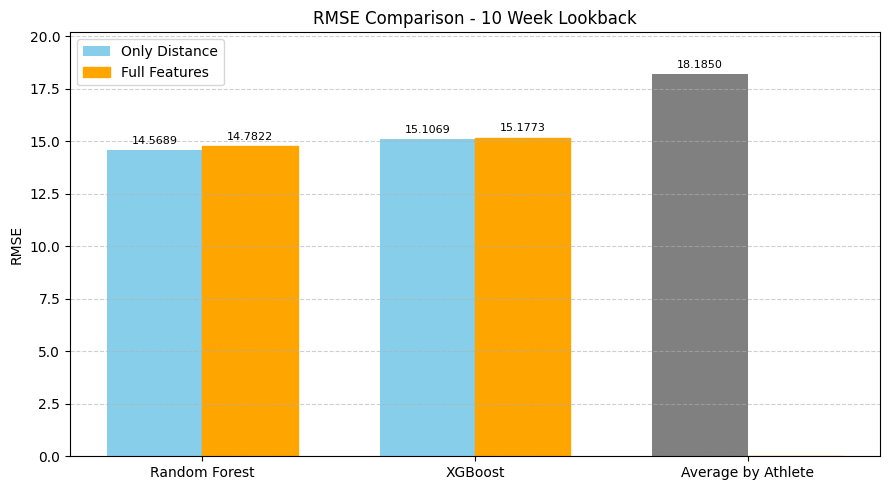

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data
models = ['Random Forest', 'XGBoost', 'Average by Athlete']
rmse_distance_only = [14.5689, 15.1069, 18.1849842]  # Use gray for Random
rmse_full_features = [14.7822, 15.1773, 0]  # No full-feature version for Random

# X positions
x = np.arange(len(models))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(x - width/2, rmse_distance_only, width, label='Only Distance', color=['skyblue', 'skyblue', 'gray'])
bars2 = ax.bar(x + width/2, rmse_full_features, width, label='Full Features', color=['orange', 'orange', 'white'], edgecolor='orange')

# Labels and layout
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison - 10 Week Lookback')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, max(max(rmse_distance_only), max(rmse_full_features)) + 2)
ax.legend()

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [96]:
import scipy.stats as stats
import numpy as np

# Given values
sample_mean = 15.5248
sample_std_dev = 0.3367
population_mean = 17.88830982301618
n = 5

# Calculate t-statistic
t_stat = (sample_mean - population_mean) / (sample_std_dev / np.sqrt(n))

# Degrees of freedom
df = n - 1

# p-value for two-tailed test
p_value = stats.t.sf(np.abs(t_stat), df) * 2
p_value


np.float64(9.62261235220306e-05)

### LSTM model

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm

In [9]:
df = df_2019
df['week'] = df['datetime'].apply(lambda date: date.isocalendar()[1])
df['gender'] = df['gender'].eq('M')

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['athlete', 'datetime'])

# Drop any row with missing required values (or handle them differently)
df = df.dropna(subset=['distance', 'duration', 'gender', 'age_group', 'country'])


target_col = 'distance'
df['age_group'] = df['age_group'].apply(lambda x: age_map[x])

In [13]:
df = df.drop(columns=['country', 'major'])

In [18]:
lookback = 5
week = 35

In [19]:
# Filter your DataFrame
X = df[(df['week'] <= week) & (df['week'] >= week - lookback)]

# Get unique athletes
unique_athletes = X['athlete'].unique()
np.random.seed(42)
np.random.shuffle(unique_athletes)  # Shuffle to randomize the split

# Split indices
split_idx = int(len(unique_athletes) * 0.7)
train_athletes = unique_athletes[:split_idx]
test_athletes = unique_athletes[split_idx:]

# Create train and test sets based on athlete inclusion
X_train = X[X['athlete'].isin(train_athletes)]
X_test = X[X['athlete'].isin(test_athletes)]

In [20]:

feature_cols = [col for col in X_train.columns if col not in ['athlete', 'datetime', 'within-month-before', 'within-month-after', 'week', 'gender', 'duration']]

In [21]:
X_seqs, y_targets = [], []
scalers = {}

for athlete_id, group in tqdm(X.groupby('athlete')):
    group = group.sort_values('datetime')
    if len(group) < lookback+1:
        print("BAD")
        continue
    
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(group[feature_cols])
    scalers[athlete_id] = scaler

    target_vals = group[target_col].values

    # Create non-overlapping sequences
    for i in range(0, len(group) - lookback + 2, lookback + 1):
        X_seqs.append(scaled[i:i+lookback])              # first 5
        y_targets.append(target_vals[i+lookback])        # 6th

100%|██████████| 36083/36083 [01:30<00:00, 397.37it/s]


In [22]:
# Convert to numpy arrays
X = np.array(X_seqs)  # shape: (samples, time_steps, features)
y = np.array(y_targets).reshape(-1, 1)

print(f"LSTM Input Shape: {X.shape}")  # (samples, time_steps, features)

# --- LSTM Model ---
model = Sequential()

model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), activation='sigmoid'))
model.add(Dense(1))  # Output: predict next duration
model.compile(loss='mse', optimizer='adam')
model.summary()

# Train the model
model.fit(X, y, epochs=5, batch_size=64, verbose=1)

LSTM Input Shape: (36083, 5, 2)


c:\Users\ewarta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,473 (1.01 MB)

 Trainable params: 265,473 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 1283.1725
Epoch 2/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1031.0537
Epoch 3/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1046.1333
Epoch 4/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 972.0887
Epoch 5/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 881.0052


In [23]:
X_test_seqs = []
y_test_targets = []

for athlete_id, group in X_test.groupby('athlete'):
    group = group.sort_values('datetime')
    if len(group) < 5:  # Ensure each athlete has enough data
        continue
    
    # Scale using the scaler trained on the training data
    scaled = scalers[athlete_id].transform(group[feature_cols])
    
    # Create sequences of 5 time steps
    for i in range(len(group) - lookback):
        X_test_seqs.append(scaled[i:i+lookback])  # 5 time steps for each sample
        y_test_targets.append(group[target_col].values[i+lookback])  # Actual value to predict (next value)

# Convert to numpy arrays
X_test_input = np.array(X_test_seqs)
y_test_input = np.array(y_test_targets).reshape(-1, 1)

print(f"X_test Shape: {X_test_input.shape}")


X_test Shape: (10825, 5, 2)


In [24]:
# Predict on the test set
y_pred = model.predict(X_test_input)


339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_input, y_pred))
print(f"RMSE: {rmse}")


RMSE: 29.61234964064593


In [27]:
# Accuracy within multiple tolerance levels
tolerances = [round(t, 1) for t in np.arange(0.1, 1.1, 0.1)]

for tolerance in tolerances:
    within_tolerance = np.abs(y_test_input - y_pred) <= tolerance
    accuracy = np.mean(within_tolerance)
    print(f"Accuracy within ±{tolerance}: {accuracy * 100:.2f}%")


Accuracy within ±0.1: 0.21%
Accuracy within ±0.2: 0.42%
Accuracy within ±0.3: 0.70%
Accuracy within ±0.4: 0.98%
Accuracy within ±0.5: 1.24%
Accuracy within ±0.6: 1.48%
Accuracy within ±0.7: 1.73%
Accuracy within ±0.8: 1.93%
Accuracy within ±0.9: 2.11%
Accuracy within ±1.0: 2.24%


In [ ]:
X_test[X_test['athlete'] == 1]

In [ ]:
X_input.shape

In [ ]:
X_train.shape